# Splines 

This shows how to specify and fit a Bayesian Splines regression model in Bambi. This example is based on [this example]() from the PyMC docs.

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")

## Load Cherry Blossom data

Richard McElreath popularized the Chery Blossom dataset in the second edition of his excellent book Statistical Rethinking. This dataset is a time series of the day in the year when the first bloom is observed for Japanese cherry blossoms. In his book, Richard McElreath uses this dataset to introduce Basis Splines, or B-Splines in short. 

Here we use Bambi to fit a linear model using a B-Spline with the Cherry Blossom data. This dataset can be loaded with Bambi as follows:

In [3]:
data = bmb.load_data("cherry_blossoms")
data

,year,doy,temp,temp_upper,temp_lower
0,801,NaN,NaN,NaN,NaN
1,802,NaN,NaN,NaN,NaN
2,803,NaN,NaN,NaN,NaN
3,804,NaN,NaN,NaN,NaN
4,805,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1210,2011,99.0,NaN,NaN,NaN
1211,2012,101.0,NaN,NaN,NaN
1212,2013,93.0,NaN,NaN,NaN
1213,2014,94.0,NaN,NaN,NaN


The variable we are interested in modeling is `"doy"`, which stands for Day of Year. Note it contains several missing values, which we discard next.

In [4]:
data = data.dropna(subset=["doy"]).reset_index(drop=True)
data.shape

(827, 5)

## Explore the data

Let's get started by creating a scatterplot to explore the values of `"doy"` for each year in the dataset.

In [5]:
# We create a function because this plot is going to be created again later
def plot_scatter(data, figsize=(10, 6)):
    _, ax = plt.subplots(figsize=figsize)
    ax.scatter(data["year"], data["doy"], alpha=0.4, s=20)
    ax.set_title("Day of the first bloom per year")
    ax.set_xlabel("Year")
    ax.set_ylabel("Days of the first bloom")
    return ax

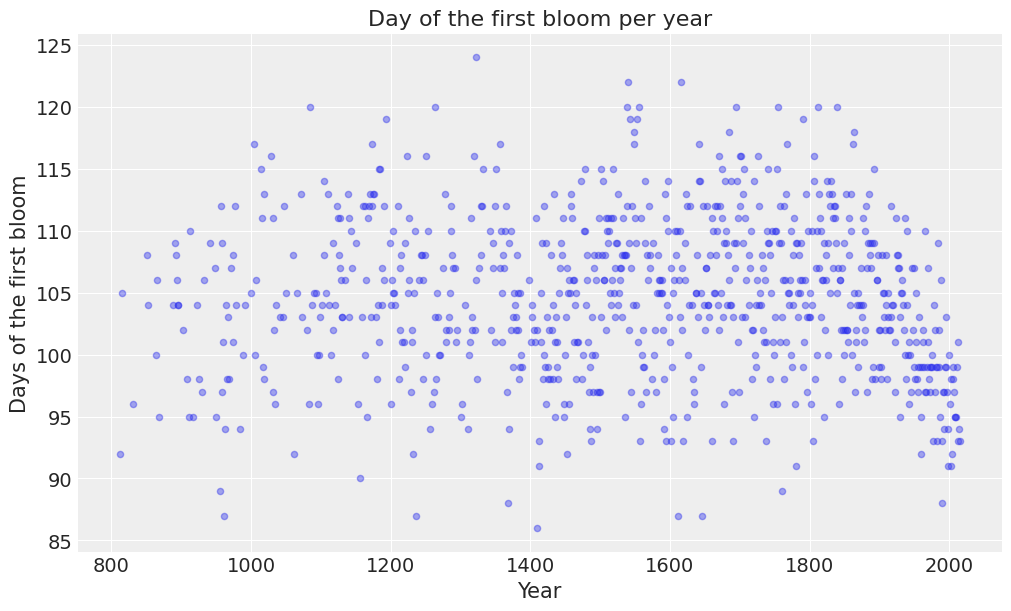

In [6]:
plot_scatter(data);

Here we can observe the day of the first bloom ranges between 85 and 125 approximately, which correspond to late March and early May respectively. On average, the first bloom occurs on the 105th day of the year, which is middle April.

## Determine knots

The spline will have 15 knots. These knots are the boundaries of the basis functions and split the range of the `"year"` variable into 16 contiguous sections. These basis functions make up a piecewise continuous polynomial, and so they are enforced to meet at the knots. We use the default degree for each piecewise polynomial, which is 3, and is known as **cubic spline**.

Since we use the quantiles, the knots are distributed unevenly over the range of `"year"` in such a way there is a similar proportion of values between each section.

In [7]:
num_knots = 15
knots = np.quantile(data.year, np.linspace(0, 1, num_knots))

In [8]:
def plot_knots(knots, ax):
    for knot in knots:
        ax.axvline(knot, color="0.1", alpha=0.4)
    return ax

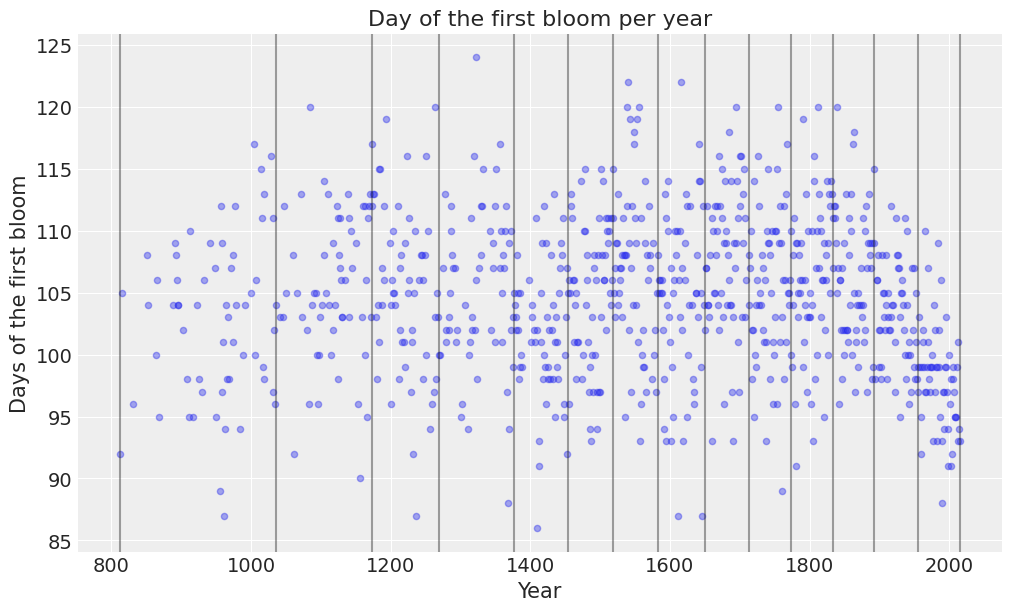

In [9]:
ax = plot_scatter(data)
plot_knots(knots, ax);

The previous chart makes it easy to see the knots, represented by the vertical lines, are spaced unevenly over the years.

## The model

$$
\begin{aligned}
Y_i & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \sum_{k=1}^K{w_kB_{k, i}} \\
\end{aligned}
$$


The second line tells that for each observation $i$, the mean is influenced by all the basis functions (going from $k=1$ to $k=K$)

And the priors are 

$$
\begin{aligned}
\alpha & \sim \text{Normal}(100, 10) \\
w_j & \sim \text{Normal}(0, 3)\\
\sigma & \sim \text{Exponential(1)}
\end{aligned}
$$

where $j = 1, \cdots, 15$


In [10]:
# We only pass the internal knots to the `bs()` function.
iknots = knots[1:-1]

# Define dictionary of priors
priors = {
    "common": bmb.Prior("Normal", mu=0, sigma=3), 
    "Intercept": bmb.Prior("Normal", mu=100, sigma=10),
    "sigma": bmb.Prior("Exponential", lam=1)
}

# Define model
# The intercept=True means the basis also spans the intercept, as originally done in the book example.
model = bmb.Model("doy ~ bs(year, knots=iknots, intercept=True)", data, priors=priors)
model

Formula: doy ~ bs(year, knots=iknots, intercept=True)
Family name: Gaussian
Link: identity
Observations: 827
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 100, sigma: 10)
    bs(year, knots = iknots, intercept = True) ~ Normal(mu: 0, sigma: 3)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)


In [11]:
def plot_spline_basis(basis, year, figsize=(10, 6)):
    df = (
        pd.DataFrame(basis)
        .assign(year=year)
        .melt("year", var_name="basis_idx", value_name="value")
    )

    _, ax = plt.subplots(figsize=figsize)

    for idx in df.basis_idx.unique():
        d = df[df.basis_idx == idx]
        ax.plot(d["year"], d["value"])
    
    return ax

The b-spline basis is plotted below, showing the "domain" of each piece of the spline.  The height of each curve indicates how "influential" the corresponding model covariate (one per spline region) will be on model's "inference" of that region.  (The quotes are to indicate that these words were chosen to help with interpretation and are not the proper mathematical terms.)  The overlapping regions represent the knots, showing how the smooth transition from one region to the next is formed.

Below, we create a chart to visualize the b-spline basis. The overlap between the functions means that, at any given point in time, the regression function is influenced by more than one basis function. For example, if we look at the year 1200, we can see the regression line is going to be influenced mostly by the violet and brown functions, and to a lesser extent by the green and cyan ones. In summary, this is what enables us to capture local patterns in a smooth fashion.

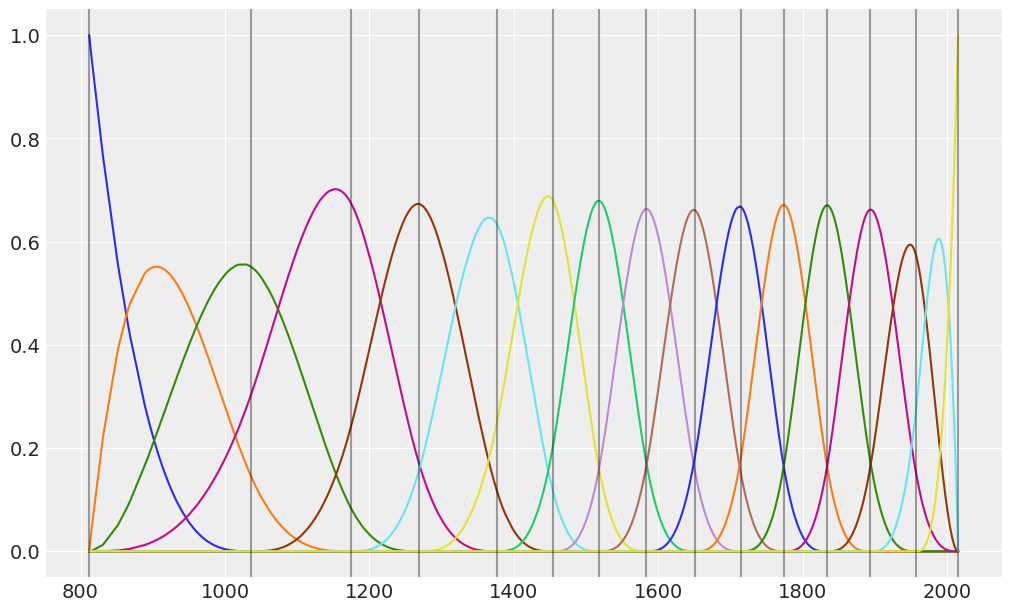

In [12]:
B = model._design.common["bs(year, knots = iknots, intercept = True)"]
ax = plot_spline_basis(B, data["year"].values)
plot_knots(knots, ax);


## Fit model

Now we fit the model. In Bambi, it is as easy as calling the `.fit()` method on the `model` instance.

In [13]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [doy_sigma, bs(year, knots = iknots, intercept = True), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


## Analisys of the results

It is always good to use `az.summary()` to verify parameter estimates as well as effective sample sizes and R hat values. In this case, the main goal is not to interpret the coefficients of the basis spline, but analyze the `ess` and `r_hat` diagnostics. In first place, almost all effective sample sizes are very close to the samples obtained, 2000, which is good. The only exception is the intercept, but it still looks good because its ESS values are above 1000. Finally, the `r_hat` diagnostic is 1 for all the parameters, indicating a good mix between the chains.

In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,103.747,0.751,102.374,105.124,0.023,0.016,1082.0,1466.0,1.0
"bs(year, knots = iknots, intercept = True)[0]",-1.864,2.210,-6.166,2.055,0.042,0.041,2789.0,1550.0,1.0
"bs(year, knots = iknots, intercept = True)[1]",-1.701,2.118,-5.598,2.330,0.045,0.040,2259.0,1612.0,1.0
"bs(year, knots = iknots, intercept = True)[2]",-0.373,1.937,-4.079,3.227,0.042,0.038,2098.0,1478.0,1.0
"bs(year, knots = iknots, intercept = True)[3]",3.245,1.481,0.508,6.042,0.033,0.024,1965.0,1720.0,1.0
"bs(year, knots = iknots, intercept = True)[4]",0.067,1.545,-2.946,2.854,0.036,0.032,1801.0,1357.0,1.0
"bs(year, knots = iknots, intercept = True)[5]",1.997,1.592,-1.135,4.888,0.034,0.025,2186.0,1822.0,1.0
"bs(year, knots = iknots, intercept = True)[6]",-3.644,1.455,-6.458,-1.082,0.034,0.024,1884.0,1585.0,1.0
"bs(year, knots = iknots, intercept = True)[7]",5.427,1.478,2.851,8.422,0.034,0.024,1911.0,1609.0,1.0
"bs(year, knots = iknots, intercept = True)[8]",-0.152,1.501,-2.933,2.668,0.035,0.028,1815.0,1813.0,1.0


We can also use `az.plot_trace()` to visualize the marginal posteriors and the sampling paths. These traces show a stationary random pattern. If these paths were not random stationary, we would be concerned about the convergence of the chains.

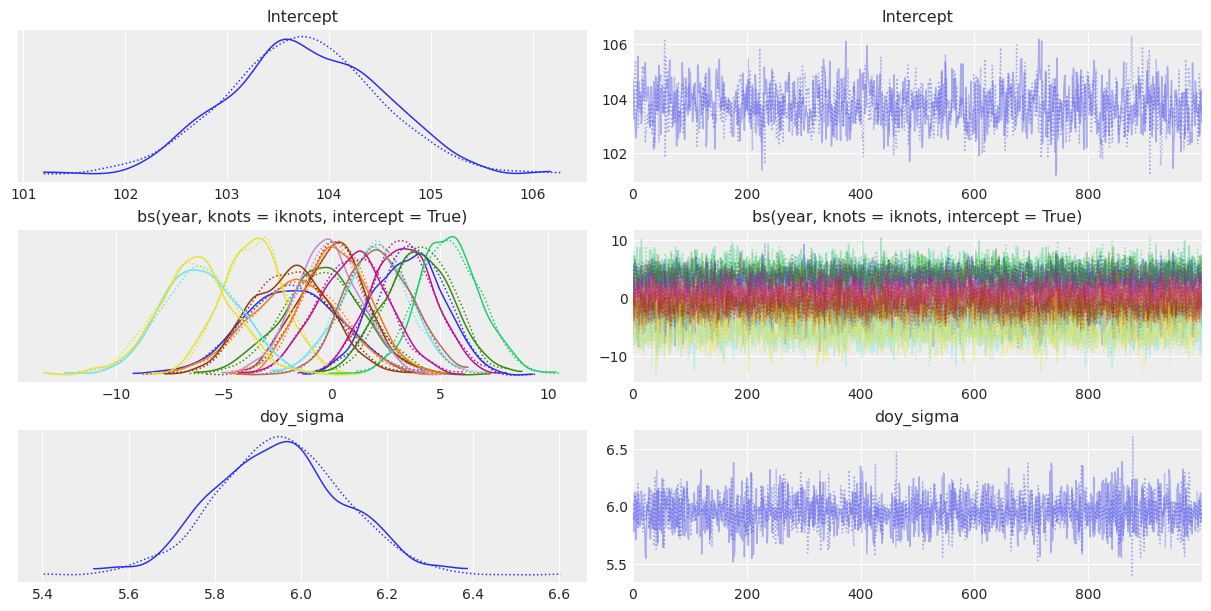

In [15]:
az.plot_trace(idata);

Another visualization of the fit spline values is to plot them multiplied against the basis matrix. The knot boundaries are shown in gray again, but now the spline basis is multipled against the values of $w$ (represented as the rainbow-colored curves). The dot product of $B$ and $w$ – the actual computation in the linear model – is shown in blue.

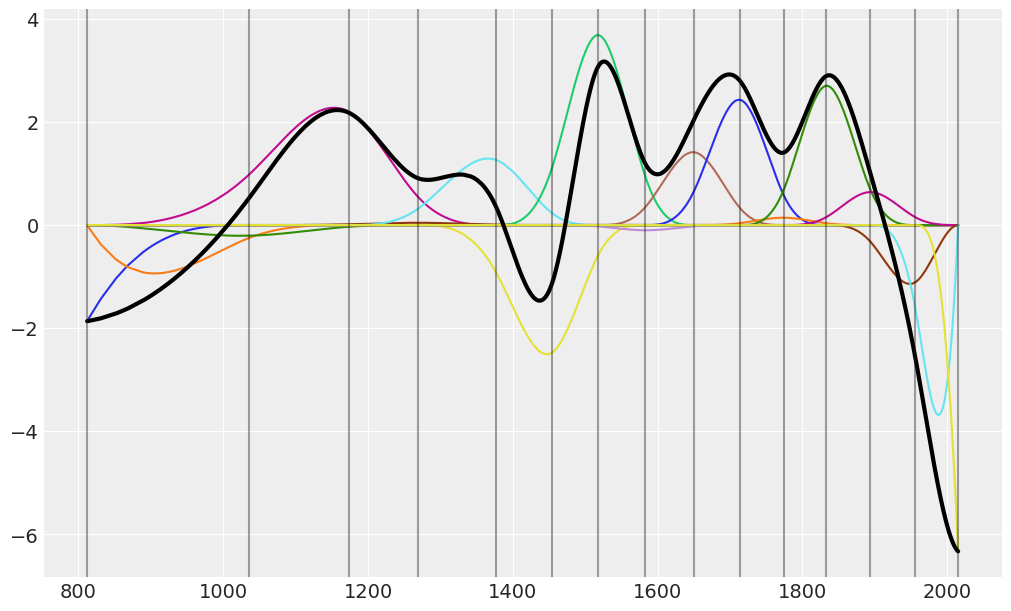

In [16]:
wp = idata.posterior["bs(year, knots = iknots, intercept = True)"].values.mean(axis=(0, 1))

ax = plot_spline_basis(B * wp.T, data["year"].values)
ax.plot(data.year.values, np.dot(B, wp.T), color="black", lw=3)
plot_knots(knots, ax);

## Plot predictions and credible bands

In [17]:
def plot_predictions(data, idata, model):
    # Create a test dataset with observations spanning the whole range of year
    new_data = pd.DataFrame({"year": np.linspace(data.year.min(), data.year.max(), num=500)})
    
    # Predict the day of first blossom
    model.predict(idata, data=new_data)

    # Extract these predictions
    y_hat = idata.posterior["doy_mean"].values

    # Compute the mean of the predictions, plotted as a single line.
    y_hat_mean = y_hat.mean((0, 1))

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(y_hat, [0.03, 0.97], axis=(0, 1))

    # Plot obserevd data
    ax = plot_scatter(data)
    
    # Plot predicted line
    ax.plot(new_data["year"], y_hat_mean, color="firebrick")
    
    # Plot credibility bands
    ax.fill_between(new_data["year"], hdi_data[0], hdi_data[1], alpha=0.4, color="firebrick")
    
    # Add knots
    plot_knots(knots, ax)
    
    return ax

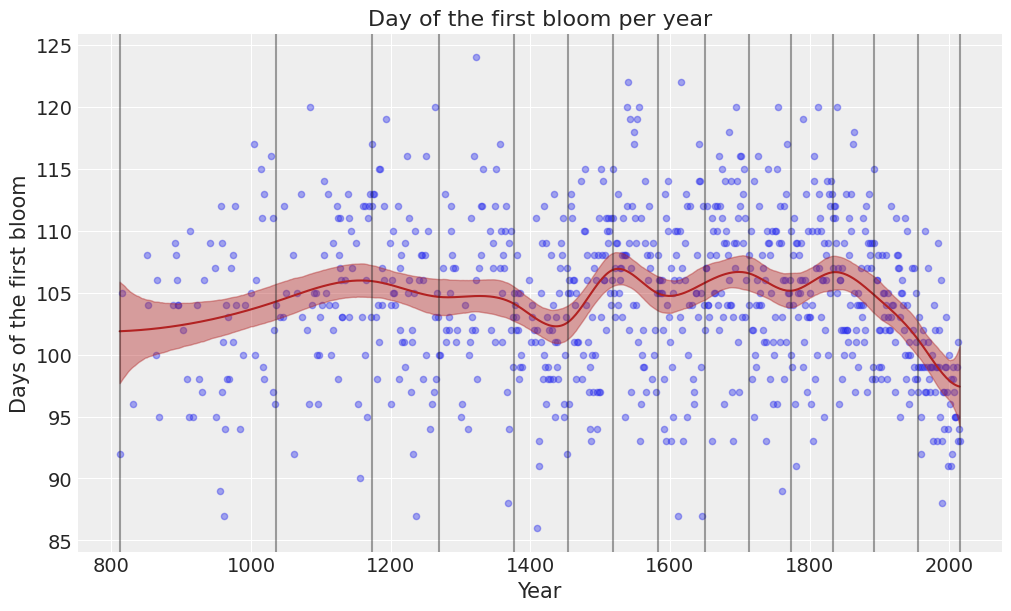

In [18]:
plot_predictions(data, idata, model);

## Advanced: Better think twice about the underlying design matrix

The model we've been using so far. We include the intercept as a common term, and span it with the spline basis too. Note that I'm changing the value of `sigma` in the priors for the common terms from 3 to 10.

In [19]:
priors_1 = {
    "common": bmb.Prior("Normal", mu=0, sigma=10), 
    "Intercept": bmb.Prior("Normal", mu=100, sigma=10),
    "sigma": bmb.Prior("Exponential", lam=1)
}

# Define model
# The intercept=True means the basis also spans the intercept, as originally done in the book example.
model_1 = bmb.Model("doy ~ bs(year, knots=iknots, intercept=True)", data, priors=priors_1)
model_1

Formula: doy ~ bs(year, knots=iknots, intercept=True)
Family name: Gaussian
Link: identity
Observations: 827
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 100, sigma: 10)
    bs(year, knots = iknots, intercept = True) ~ Normal(mu: 0, sigma: 10)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)


Do not include the intercept as a common term, but span the intercept in the spline basis

In [20]:
priors_2 = {
    "common": bmb.Prior("Normal", mu=100, sigma=10), 
    "sigma": bmb.Prior("Exponential", lam=1)
}
model_2 = bmb.Model("doy ~ 0 + bs(year, knots=iknots, intercept=True)", data, priors=priors_2)
model_2

Formula: doy ~ 0 + bs(year, knots=iknots, intercept=True)
Family name: Gaussian
Link: identity
Observations: 827
Priors:
  Common-level effects
    bs(year, knots = iknots, intercept = True) ~ Normal(mu: 100, sigma: 10)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)


Include the intercept as a common term and do not span it in the spline basis

In [21]:
priors_3 = {
    "common": bmb.Prior("Normal", mu=0, sigma=10), 
    "Intercept": bmb.Prior("Normal", mu=100, sigma=10),
    "sigma": bmb.Prior("Exponential", lam=1)
}
model_3 = bmb.Model("doy ~ bs(year, knots=iknots)", data, priors=priors_3)
model_3

Formula: doy ~ bs(year, knots=iknots)
Family name: Gaussian
Link: identity
Observations: 827
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 100, sigma: 10)
    bs(year, knots = iknots) ~ Normal(mu: 0, sigma: 10)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)


### Fit models

In [22]:
idata_1 = model_1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [doy_sigma, bs(year, knots = iknots, intercept = True), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


In [23]:
idata_2 = model_2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [doy_sigma, bs(year, knots = iknots, intercept = True)]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


In [24]:
idata_3 = model_3.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [doy_sigma, bs(year, knots = iknots), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


### Explore predictions

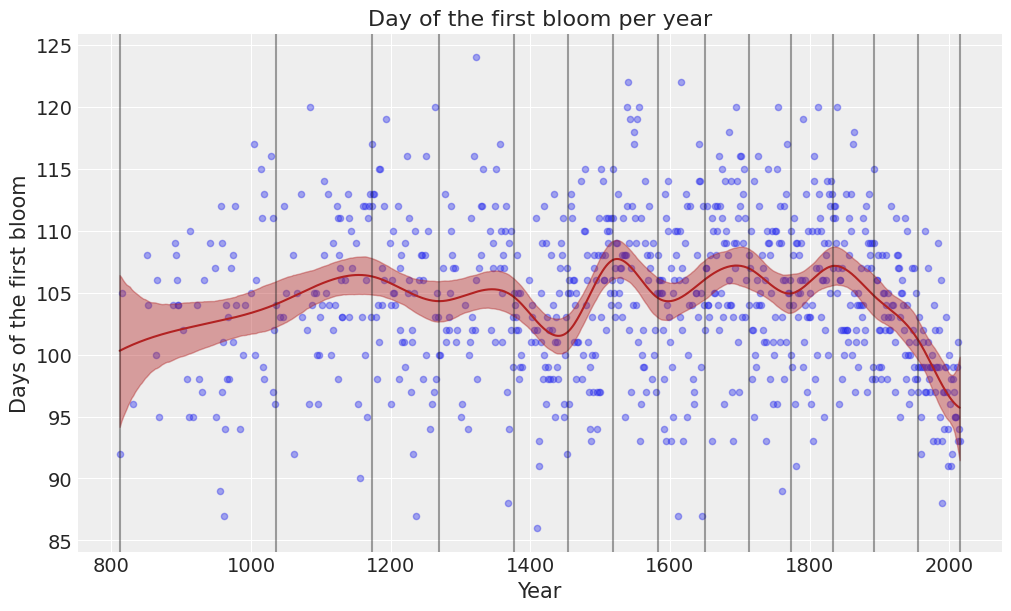

In [25]:
plot_predictions(data, idata_1, model_1);

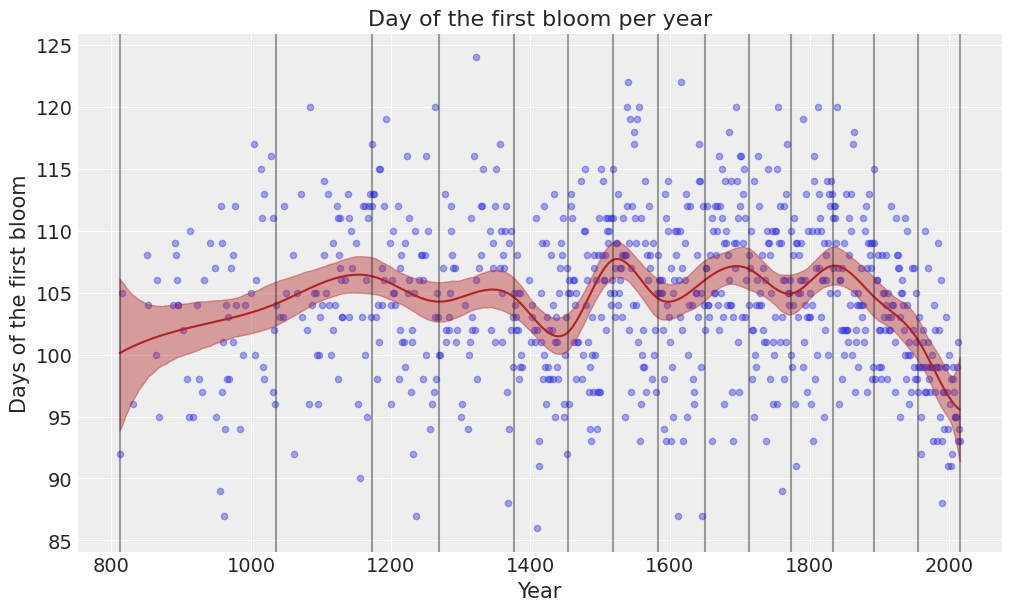

In [26]:
plot_predictions(data, idata_2, model_2);

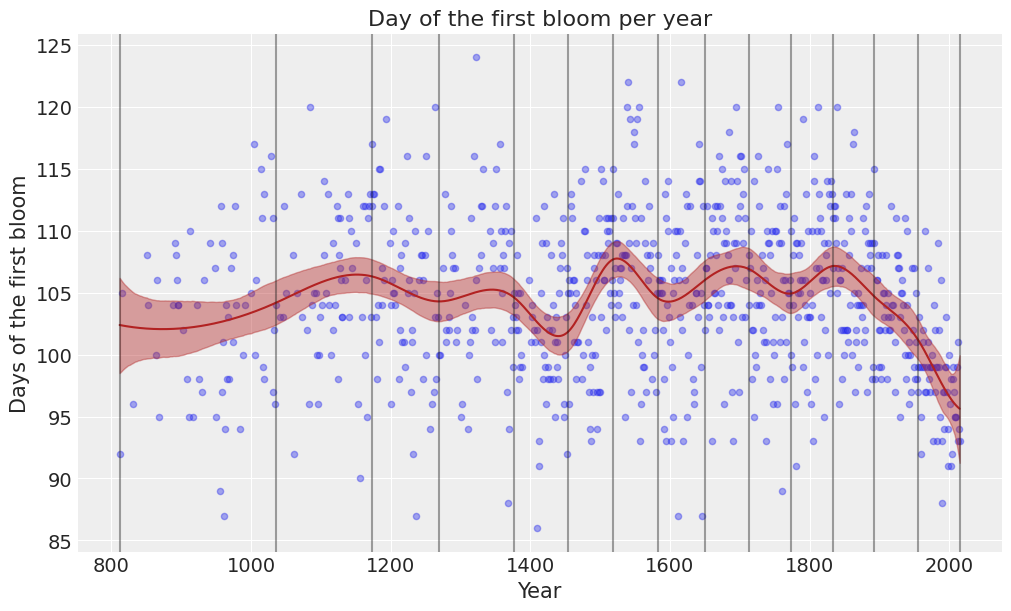

In [27]:
plot_predictions(data, idata_3, model_3);

### Compare models

In [28]:
models_dict = {
    "model_1": idata_1,
    "model_2": idata_2,
    "model_3": idata_3
}
df_compare = az.compare(models_dict)
df_compare

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_3,0,-2658.047975,16.110522,0.000000,1.000000e+00,21.152998,0.000000,False,log
model_2,1,-2658.302265,16.628316,0.254290,1.665335e-16,21.168282,0.643880,True,log
model_1,2,-2658.348837,16.675273,0.300863,0.000000e+00,21.199825,0.592278,False,log


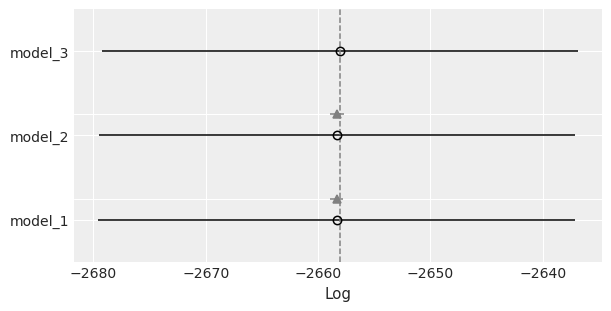

In [29]:
az.plot_compare(df_compare, insample_dev=False);

### More explorations

In [30]:
# Compute pointwise LOO
loo_1 = az.loo(idata_1, pointwise=True)
loo_2 = az.loo(idata_2, pointwise=True)
loo_3 = az.loo(idata_3, pointwise=True)

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


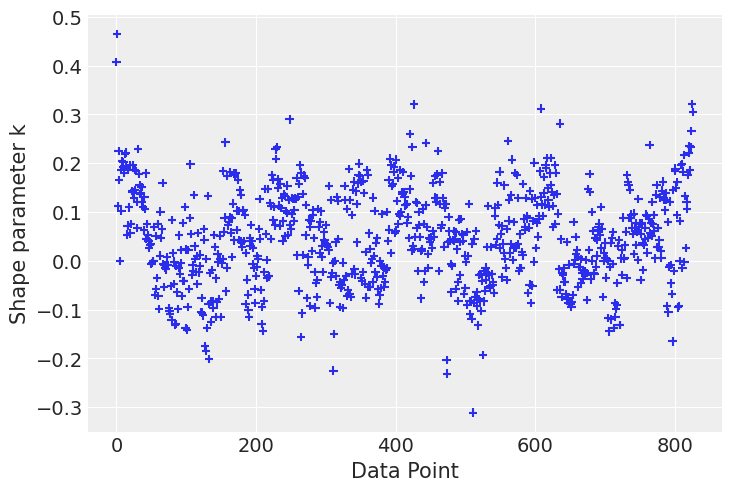

In [31]:
# plot kappa values
az.plot_khat(loo_1.pareto_k);

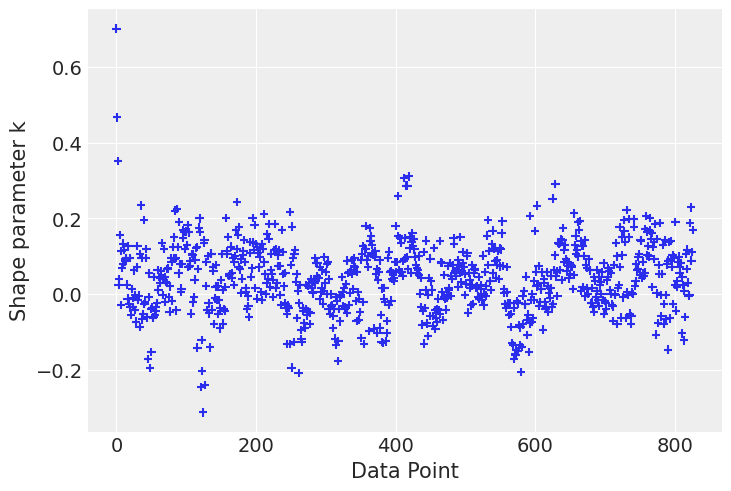

In [32]:
az.plot_khat(loo_2.pareto_k);

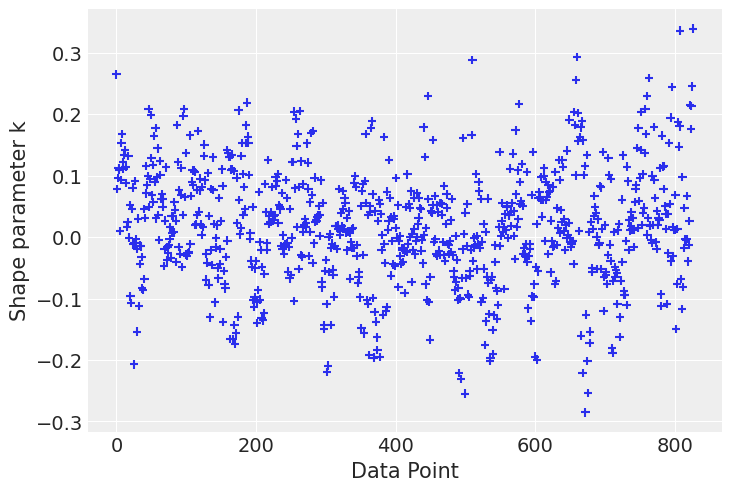

In [33]:
az.plot_khat(loo_3.pareto_k);

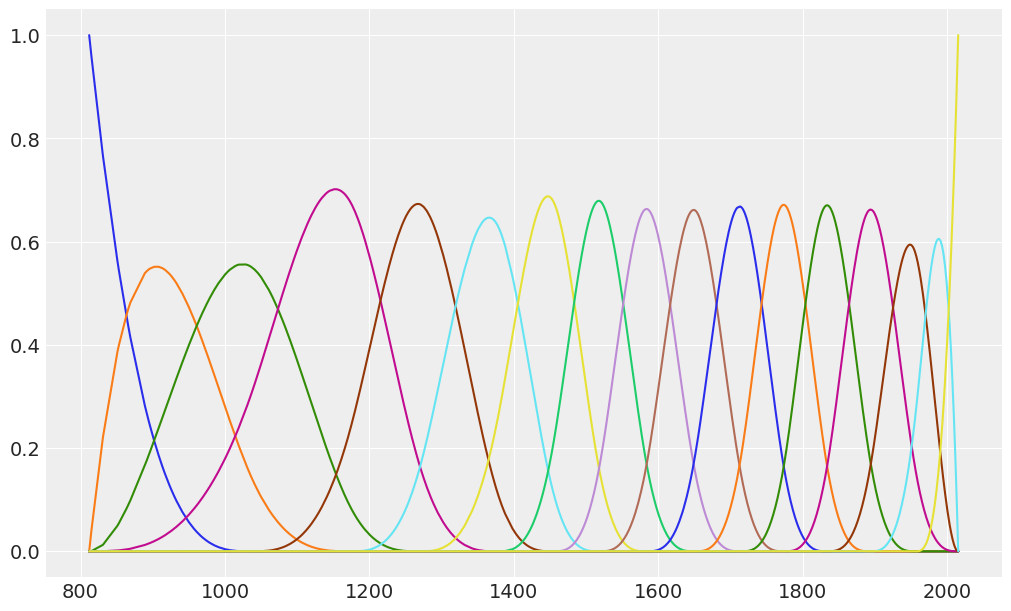

In [34]:
B = model_1._design.common["bs(year, knots = iknots, intercept = True)"]
ax = plot_spline_basis(B, data["year"].values)

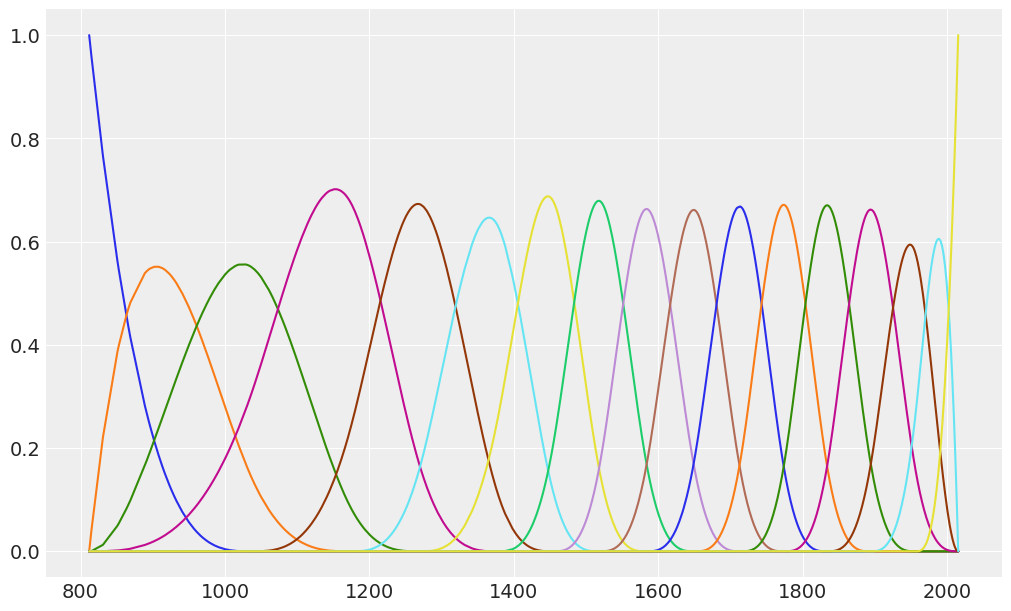

In [35]:
B = model_2._design.common["bs(year, knots = iknots, intercept = True)"]
ax = plot_spline_basis(B, data["year"].values)

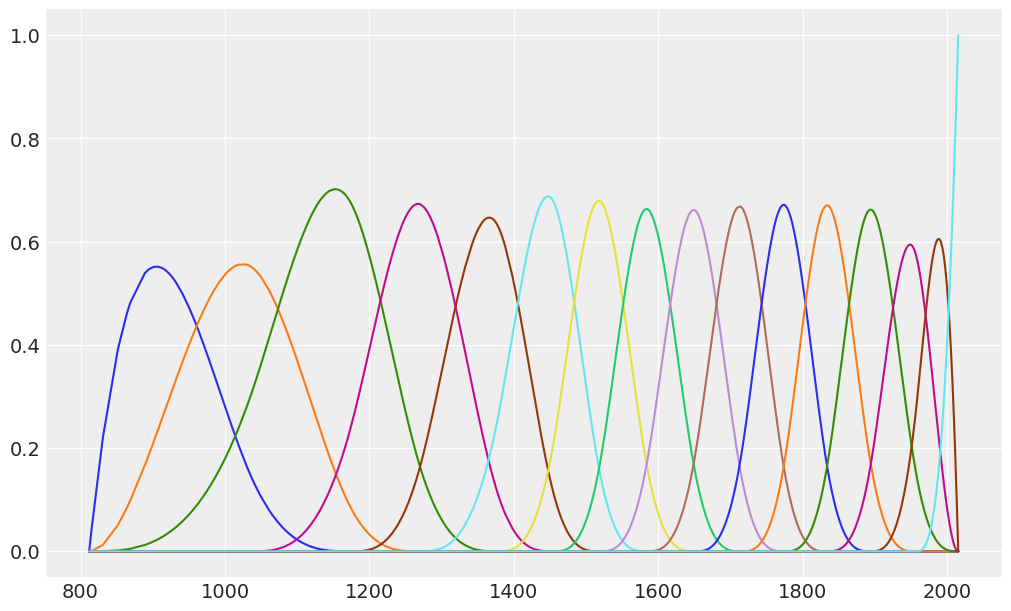

In [36]:
B = model_3._design.common["bs(year, knots = iknots)"]
ax = plot_spline_basis(B, data["year"].values)

In [37]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Oct 23 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

bambi     : 0.6.3
sys       : 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
pandas    : 1.3.2
matplotlib: 3.4.3
numpy     : 1.20.3
arviz     : 0.11.2

Watermark: 2.1.0

